<a href="https://colab.research.google.com/github/sabatn/NN/blob/main/NN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch torchvision datasets transformers scikit-learn matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
Using cached nvidia_cublas_

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings
from transformers import BertTokenizer, BertModel

In [6]:
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("huggingface_hub").setLevel(logging.ERROR)

Using device: cpu
Loading dataset...
Dataset shape: (120000, 2)
Dropped 'label' column. New shape: (120000, 1)

Dataset sample:
                                                text
0  Wall St. Bears Claw Back Into the Black (Reute...
1  Carlyle Looks Toward Commercial Aerospace (Reu...
2  Oil and Economy Cloud Stocks' Outlook (Reuters...
3  Iraq Halts Oil Exports from Main Southern Pipe...
4  Oil prices soar to all-time record, posing new...

Initializing BERT model...

Sampling 5000 examples from 120000 total...

Extracting BERT embeddings...
Embeddings shape: (5000, 768)

Applying PCA for dimensionality reduction...
Reduced embeddings shape: (5000, 64)
Explained variance ratio: 0.7010

Training autoencoder...
Epoch [10/100], Loss: 0.102924
Epoch [20/100], Loss: 0.087185
Epoch [30/100], Loss: 0.080098
Epoch [40/100], Loss: 0.075420
Epoch [50/100], Loss: 0.072457
Epoch [60/100], Loss: 0.070192
Epoch [70/100], Loss: 0.068409
Epoch [80/100], Loss: 0.067014
Epoch [90/100], Loss: 0.065837


<ipython-input-7-8f29f2d843ac>:164: UserWarning: Silhouette Score: 0.0931
  warnings.warn(f"Silhouette Score: {silhouette:.4f}")
<ipython-input-7-8f29f2d843ac>:165: UserWarning: Davies-Bouldin Index: 2.7669
  warnings.warn(f"Davies-Bouldin Index: {davies_bouldin:.4f}")


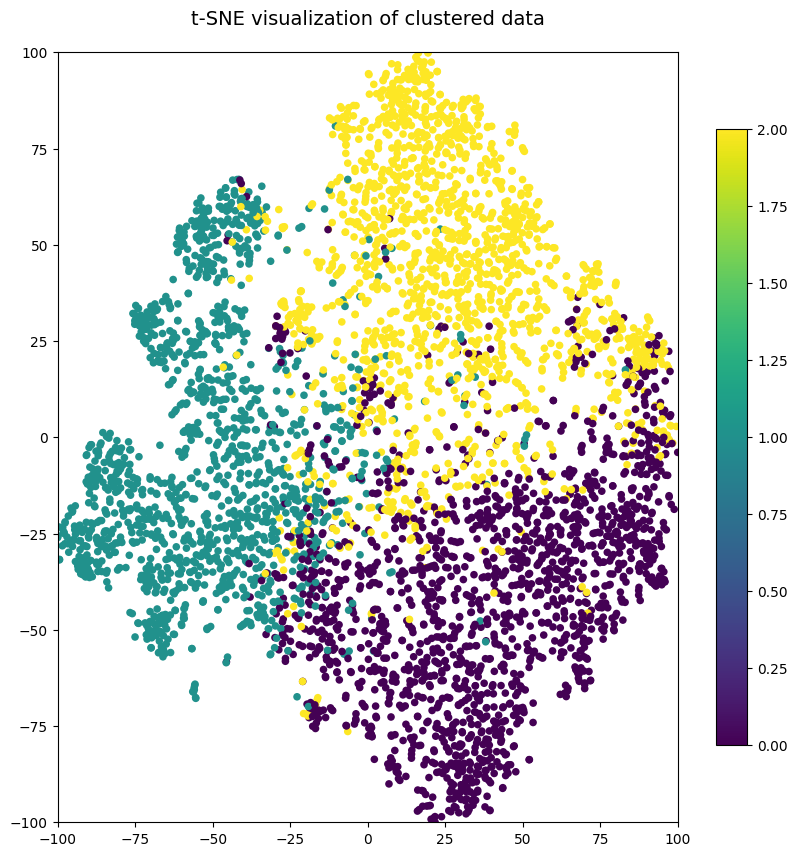


Analyzing cluster contents...
Cluster 0: 1829 samples (36.58%)
Sample texts:
- Flight attendants union chief wants strike PITTSBURGH -- The president of the United States #39; lar...
- Vietnam Hails Shrimp Tariff Reduction Vietnam seafood exporters and producers on Wednesday hailed a ...
- Powell Tackles Illegal Immigrant Issue (AP) AP - An end to the U.S. political season coupled with en...
Cluster 1: 1469 samples (29.38%)
Sample texts:
- Schumacher Clinches Season Title Michael Schumacher finished second at the Belgian Grand Prix on Sun...
- Powell Vows to Work Hard Until Departure (AP) AP - Secretary of State Colin Powell, widely viewed as...
- Two NCSSM students win national team science competition Two students at the Durham NC School of Sci...
Cluster 2: 1702 samples (34.04%)
Sample texts:
- UPDATE 1-US rate futures struggle despite low Aug inflation Short-term interest rate futures struggl...
- Gmail Users Soon Able to Check E-Mail Via Outlook SAN FRANCISCO -- Web search leader

In [7]:
#Setup
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Load Dataset
print("Loading dataset...")
df = pd.read_parquet("/content/train-00000-of-00001 (1).parquet")
print(f"Dataset shape: {df.shape}")

#Preprocessing
if 'label' in df.columns:
    df = df.drop(columns=['label'])
    print(f"Dropped 'label' column. New shape: {df.shape}")

print("\nDataset sample:")
print(df.head())

#BERT Embedding
text_column = 'text'
if text_column not in df.columns:
    raise ValueError(f"Text column '{text_column}' not found in dataset")

print("\nInitializing BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def extract_bert_embeddings(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)
        torch.cuda.empty_cache()
    return np.array(embeddings)

max_samples = 5000
if len(df) > max_samples:
    print(f"\nSampling {max_samples} examples from {len(df)} total...")
    df_sample = df.sample(max_samples, random_state=42)
else:
    df_sample = df

print("\nExtracting BERT embeddings...")
embeddings = extract_bert_embeddings(df_sample[text_column])
print(f"Embeddings shape: {embeddings.shape}")
#PCA Reduction
print("\nApplying PCA for dimensionality reduction...")
pca = PCA(n_components=64)
reduced_embeddings = pca.fit_transform(embeddings)
print(f"Reduced embeddings shape: {reduced_embeddings.shape}")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

#Autoencoder Definition
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))
    def encode(self, x):
        return self.encoder(x)

X_tensor = torch.FloatTensor(reduced_embeddings)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = Autoencoder(input_dim=64, hidden_dim=128, latent_dim=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Train Autoencoder
print("\nTraining autoencoder...")
losses = []
for epoch in range(100):
    model.train()
    epoch_loss = 0
    for batch_features, _ in dataloader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/100], Loss: {avg_loss:.6f}")
    torch.cuda.empty_cache()

#Extract Latent Embeddings
print("\nExtracting latent embeddings...")
model.eval()
latent_embeddings = []
with torch.no_grad():
    for batch_features, _ in dataloader:
        batch_features = batch_features.to(device)
        encoded = model.encode(batch_features).cpu().numpy()
        latent_embeddings.extend(encoded)
latent_embeddings = np.array(latent_embeddings)
print(f"Latent embeddings shape: {latent_embeddings.shape}")  # (5000, 32)

#Clustering
print("\nApplying K-means clustering...")
silhouette_scores = []
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(latent_embeddings)
    score = silhouette_score(latent_embeddings, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

optimal_k = np.argmax(silhouette_scores) + 2
print(f"\nOptimal number of clusters: {optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_embeddings)

#Evaluation
print("\nEvaluating clustering performance...")
silhouette = silhouette_score(latent_embeddings, cluster_labels)
davies_bouldin = davies_bouldin_score(latent_embeddings, cluster_labels)
print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

#t-SNE Visualization
print("\nVisualizing clusters using t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_results = tsne.fit_transform(latent_embeddings)
tsne_scaled = 200 * (tsne_results - tsne_results.min(axis=0)) / (tsne_results.max(axis=0) - tsne_results.min(axis=0)) - 100

viz_df = pd.DataFrame({
    'x': tsne_scaled[:, 0],
    'y': tsne_scaled[:, 1],
    'cluster': cluster_labels
})

plt.figure(figsize=(10, 10))
plt.rcParams['figure.facecolor'] = 'white'
scatter = plt.scatter(viz_df['x'], viz_df['y'], c=viz_df['cluster'], cmap='viridis', alpha=1.0, s=30, edgecolors='none')
cbar = plt.colorbar(scatter, shrink=0.8)
cbar.set_label('', fontsize=12)
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.title('t-SNE visualization of clustered data', fontsize=14, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
with warnings.catch_warnings():
    warnings.warn(f"Silhouette Score: {silhouette:.4f}")
    warnings.warn(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
plt.savefig('tsne_clusters_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

#Cluster Content Analysis
print("\nAnalyzing cluster contents...")
for cluster_id in range(optimal_k):
    size = np.sum(cluster_labels == cluster_id)
    print(f"Cluster {cluster_id}: {size} samples ({size/len(cluster_labels)*100:.2f}%)")
    indices = np.where(cluster_labels == cluster_id)[0]
    if len(indices) > 0:
        sample_indices = np.random.choice(indices, min(3, len(indices)), replace=False)
        print("Sample texts:")
        for idx in sample_indices:
            if idx < len(df_sample):
                text = df_sample.iloc[idx][text_column]
                print(f"- {text[:100]}..." if len(text) > 100 else f"- {text}")


